## Inversion Net Supervised Learning Setting

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys

import warnings
warnings.filterwarnings('ignore')

import tqdm
from model import *

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import scipy.ndimage

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
#     torch.cuda.set_device(0)
    device = torch.device("cuda:0")  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

Total number of GPU available - 8


In [2]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Loading Amplitude and Velocity Data for Flat Layers

In [3]:
#FlatVel examples
data1 = np.load('FlatVel-A/amplitude/data1.npy')
data2 = np.load('FlatVel-A/amplitude/data2.npy')
data3 = np.load('FlatVel-A/amplitude/data3.npy')
data4 = np.load('FlatVel-A/amplitude/data4.npy')

model1 = np.load('FlatVel-A/velocity/model1.npy')
model2 = np.load('FlatVel-A/velocity/model2.npy')
model3 = np.load('FlatVel-A/velocity/model3.npy')
model4 = np.load('FlatVel-A/velocity/model4.npy')
# print(len(model1[0:2]))
# print(data1[:100].shape)


# converting to torch tensor
# data1[:200]
data1 = torch.tensor(data1).type(dtype).to(device)
data2 = torch.tensor(data2).type(dtype).to(device)
data3 = torch.tensor(data3).type(dtype).to(device)
data4 = torch.tensor(data4).type(dtype).to(device)

model1 = torch.tensor(model1).type(dtype).to(device)
model2 = torch.tensor(model2).type(dtype).to(device)
model3 = torch.tensor(model3).type(dtype).to(device)
model4 = torch.tensor(model4).type(dtype).to(device)

## Custom Data Loader class to load data using PyTorch Dataloader

In [4]:
class DatasetLoader(Dataset):
    
    def __init__(self, amps, vel):
        self.amps = amps
        self.vel = vel
    
    
    def __getitem__(self, idx):
        
        return (self.amps[idx], self.vel[idx])
    
    def __len__(self):
        
        return len(self.amps)


In [5]:
print(model1.shape)

torch.Size([500, 1, 70, 70])


In [6]:
total_data = torch.cat((data1, data2, data3, data4), 0)
total_model = torch.cat((model1, model2, model3, model4), 0)

data = DatasetLoader(total_data, total_model)

In [7]:
# print(total_data.shape)
# print(total_data[0])
print(len(data)*0.8)

1600.0


In [8]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size

train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=50, shuffle=True)
testloader = DataLoader(test_data, batch_size=50, shuffle=True)

## Defining InversionNet model

In [9]:
input_channels = 5
encoder_channels = [32, 64, 64, 64, 64, 128, 128, 128, 128,
                   256, 256, 256, 256, 512]

decoder_channels = [512, 256, 128, 64, 32]

net = InversionNetB(input_channels, encoder_channels, decoder_channels).type(dtype).to(device)

# net = nn.DataParallel(InversionNetB(input_channels, encoder_channels, decoder_channels)).type(dtype).to(device)

#net = InversionNet().type(dtype).to(device)

In [10]:
## Optimization Params
params = [p for p in net.parameters()]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

c1 = 0.3

optimizer = torch.optim.Adam([{'params':params, 'lr':1e-6}])
# optimizer = torch.optim.SGD(params, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

  0%|                                                  | 0/5000 [00:00<?, ?it/s]

Model Loss at 0 epoch - 5822392.671875


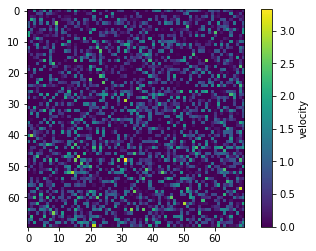

  4%|█▌                                    | 200/5000 [15:27<6:27:39,  4.85s/it]

Model Loss at 200 epoch - 5821585.109375


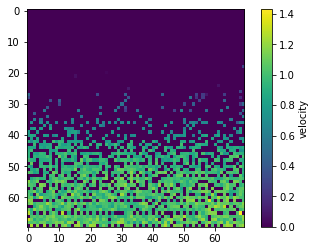

  8%|███                                   | 400/5000 [31:44<6:15:44,  4.90s/it]

Model Loss at 400 epoch - 5821534.484375


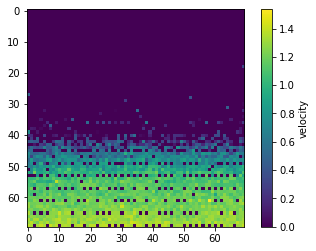

 12%|████▌                                 | 600/5000 [48:10<5:57:30,  4.88s/it]

Model Loss at 600 epoch - 5821500.46875


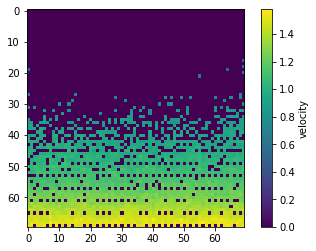

 16%|█████▊                              | 800/5000 [1:04:36<5:44:24,  4.92s/it]

Model Loss at 800 epoch - 5821464.96875


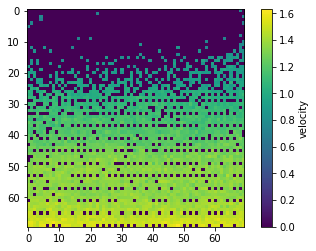

 20%|███████                            | 1000/5000 [1:20:56<5:27:13,  4.91s/it]

Model Loss at 1000 epoch - 5821435.90625


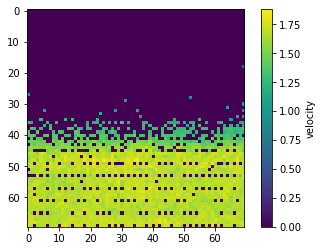

 24%|████████▍                          | 1200/5000 [1:37:25<5:09:36,  4.89s/it]

Model Loss at 1200 epoch - 5821407.859375


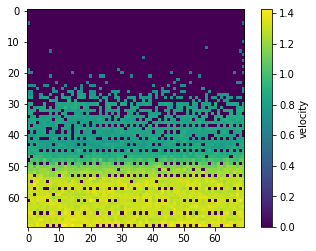

 28%|█████████▊                         | 1400/5000 [1:53:50<4:54:15,  4.90s/it]

Model Loss at 1400 epoch - 5821378.375


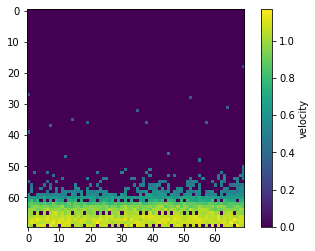

 32%|███████████▏                       | 1600/5000 [2:10:12<4:38:37,  4.92s/it]

Model Loss at 1600 epoch - 5821349.46875


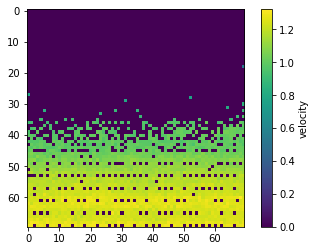

 36%|████████████▌                      | 1800/5000 [2:26:33<4:21:29,  4.90s/it]

Model Loss at 1800 epoch - 5821321.1875


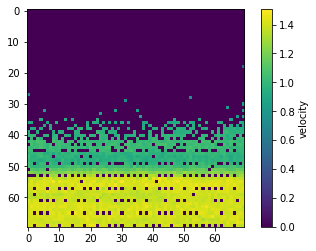

 40%|██████████████                     | 2000/5000 [2:42:53<4:05:11,  4.90s/it]

Model Loss at 2000 epoch - 5821294.28125


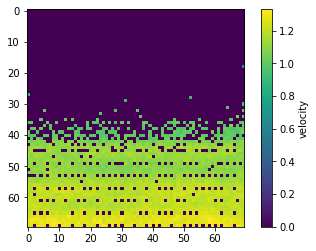

 44%|███████████████▍                   | 2200/5000 [2:59:16<3:47:44,  4.88s/it]

Model Loss at 2200 epoch - 5821268.125


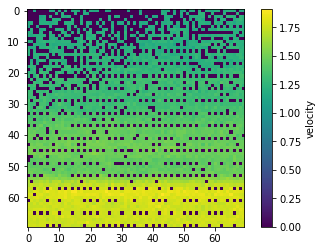

 48%|████████████████▊                  | 2400/5000 [3:15:39<3:32:29,  4.90s/it]

Model Loss at 2400 epoch - 5821239.578125


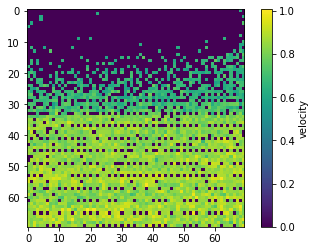

 52%|██████████████████▏                | 2600/5000 [3:32:02<3:18:04,  4.95s/it]

Model Loss at 2600 epoch - 5821211.53125


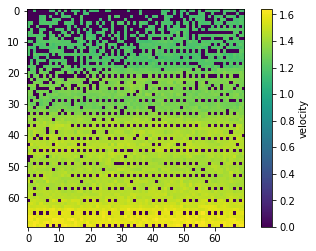

 56%|███████████████████▌               | 2800/5000 [3:48:22<3:00:50,  4.93s/it]

Model Loss at 2800 epoch - 5821185.78125


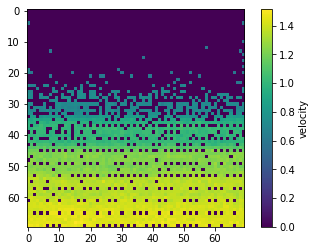

 60%|█████████████████████              | 3000/5000 [4:04:50<2:44:49,  4.94s/it]

Model Loss at 3000 epoch - 5821158.796875


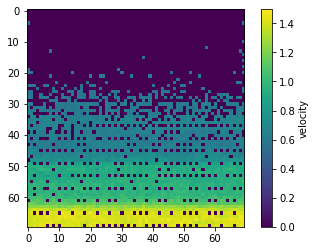

 64%|██████████████████████▍            | 3200/5000 [4:21:13<2:26:18,  4.88s/it]

Model Loss at 3200 epoch - 5821129.46875


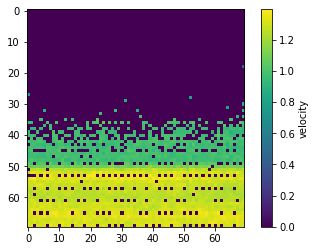

 68%|███████████████████████▊           | 3400/5000 [4:37:40<2:11:37,  4.94s/it]

Model Loss at 3400 epoch - 5821102.890625


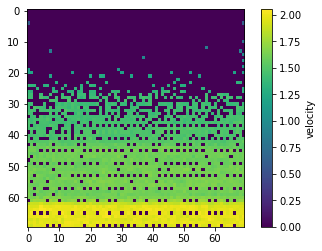

 72%|█████████████████████████▏         | 3600/5000 [4:54:06<1:54:46,  4.92s/it]

Model Loss at 3600 epoch - 5821074.0


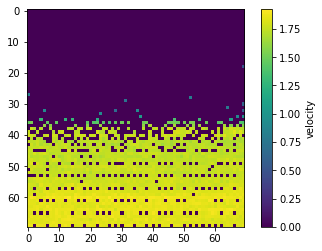

 76%|██████████████████████████▌        | 3800/5000 [5:10:31<1:39:23,  4.97s/it]

Model Loss at 3800 epoch - 5821046.734375


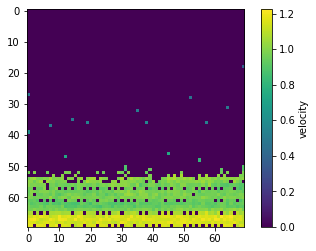

 80%|████████████████████████████       | 4000/5000 [5:26:56<1:21:49,  4.91s/it]

Model Loss at 4000 epoch - 5821019.171875


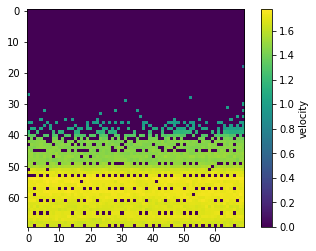

 84%|█████████████████████████████▍     | 4200/5000 [5:43:23<1:05:55,  4.94s/it]

Model Loss at 4200 epoch - 5820992.40625


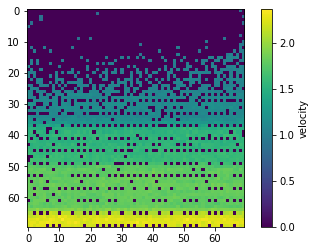

 88%|████████████████████████████████▌    | 4400/5000 [5:59:51<49:29,  4.95s/it]

Model Loss at 4400 epoch - 5820963.46875


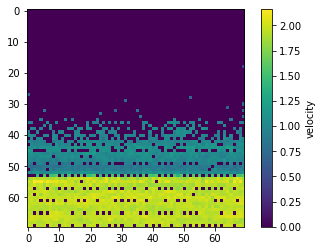

 92%|██████████████████████████████████   | 4600/5000 [6:16:24<33:13,  4.98s/it]

Model Loss at 4600 epoch - 5820936.03125


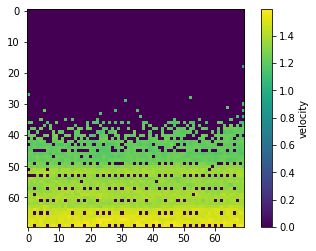

 96%|███████████████████████████████████▌ | 4800/5000 [6:32:55<16:30,  4.95s/it]

Model Loss at 4800 epoch - 5820909.421875


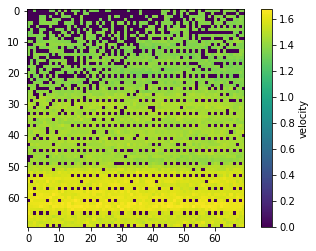

100%|█████████████████████████████████████| 5000/5000 [6:49:22<00:00,  4.91s/it]


In [10]:
# Model Training
train_loss_per_epoch = []

num_epoch = 5000

for epoch in tqdm(range(num_epoch)):
    train_epoch_loss = 0
    for batch_id, (amp, vel) in enumerate(trainloader):
        optimizer.zero_grad()
        
        pred_vel = net(amp)
        
        # Loss calculation
        loss1 = l1_loss(vel, pred_vel)
        loss2 = l2_loss(vel, pred_vel)

        pixel_loss = c1*loss1 + (1-c1)*loss2
        train_epoch_loss += pixel_loss.item()
        
        
        pixel_loss.backward()
        optimizer.step()
    
#     scheduler.step()
    train_epoch_loss = train_epoch_loss/(len(trainloader)) 
        
    if(epoch%200 == 0):
        print('Model Loss at {epoch} epoch - {epoch_loss}'.format(epoch=epoch, epoch_loss=train_epoch_loss))
        
        with torch.no_grad():
            pred_vel_np = pred_vel[0,0,:].detach().cpu().numpy()
            plt.imshow(pred_vel_np)
            plt.colorbar(label='velocity')
            plt.show()
        
    train_loss_per_epoch.append(train_epoch_loss)

In [11]:
# torch.save(net.state_dict(), 'CurveVel-B_c_0.3_weights.pth')
torch.save(net.state_dict(), 'Checkpoints/FlatVel-A/FlatVel-A_e_5000_weights.pth')

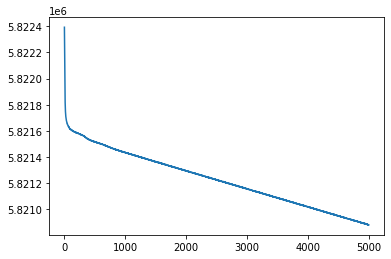

In [12]:
plt.plot(train_loss_per_epoch)
plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_5000_pixel_loss.png")

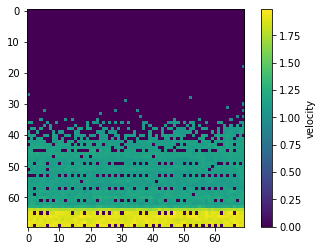

In [28]:
amp, vel = train_data[20:60]

pred_vel = net(amp)

vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')


plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_5000_train20_60_prediction.png")
plt.show()

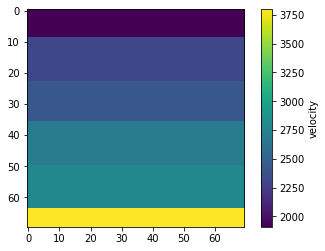

In [29]:
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_5000_train20_60_true.png")
plt.show()

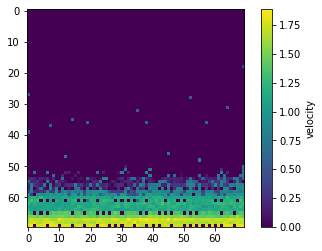

In [15]:
amp, vel = test_data[0:40]

pred_vel = net(amp)

vel = vel[10,0,:]
first_vel = pred_vel[10,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_5000_test0_40_prediction.png")
plt.show()

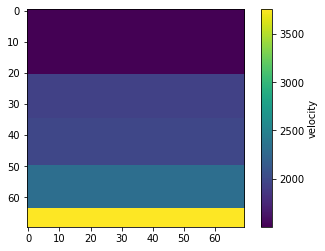

In [16]:
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/FlatVel-A/FlatVel-A_e_5000_test0_40_true.png")
plt.show()

In [12]:
# Loading Model for Inference (Adam)
model=InversionNetB(input_channels, encoder_channels, decoder_channels) #.type(dtype).to(device)
model.load_state_dict(torch.load('Checkpoints/FlatVel-A/FlatVel-A_e_2000_adam_weights.pth'))
model.eval()

InversionNetB(
  (conv_block_last): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (encoder_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 32, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 1), stride=(2, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.

Mean Absolute Error (MAE):  2784.513
Mean Relative Error (MRE):  0.9998401

Prediction


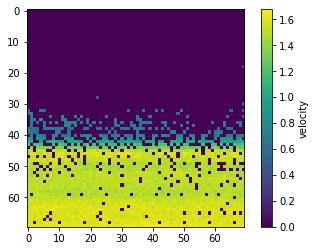

Ground Truth


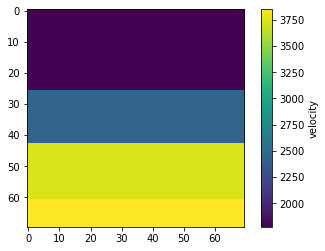

In [13]:
# Evaluation metrics - MAE and MRE
# with e=2000
amp, vel = test_data[0:]
pred_vel = model(amp.to('cpu'))

mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)
print("")
vel = vel[15,0,:]
pred_vel = pred_vel[15,0,:]

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
true_vel = vel.detach().cpu().numpy()
plt.imshow(true_vel)
plt.colorbar(label='velocity')
plt.show()

In [52]:
# with e=2000
amp, vel = test_data[0:]
model=model.module.to(torch.device('cpu'))
pred_vel = model(amp.to('cpu'))
print("MAE: ", mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)))
print("MRE: ", mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)))
# vel = vel[10,0,:]
# pred_vel = pred_vel[10,0,:]

# pred_vel = pred_vel.detach().cpu().numpy()

# plt.imshow(pred_vel)
# plt.colorbar(label='velocity')

# plt.show()

MAE:  tensor(56.9402, device='cuda:0')
MRE:  tensor(0.0199, device='cuda:0')


In [31]:
amp, vel = test_data[0:]
model=model #.module.to(torch.device('cpu'))
pred_vel = model(amp.to('cpu'))
print("MAE: ", mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)))
print("MRE: ", mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)))
# vel = vel[10,0,:]
# pred_vel = pred_vel[10,0,:]

# pred_vel = pred_vel.detach().cpu().numpy()

# plt.imshow(pred_vel)
# plt.colorbar(label='velocity')

# plt.show()

MAE:  tensor(28.2733, device='cuda:0')
MRE:  tensor(0.0091, device='cuda:0')


In [32]:
mean_squared_log_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device))

tensor(0.0003, device='cuda:0')

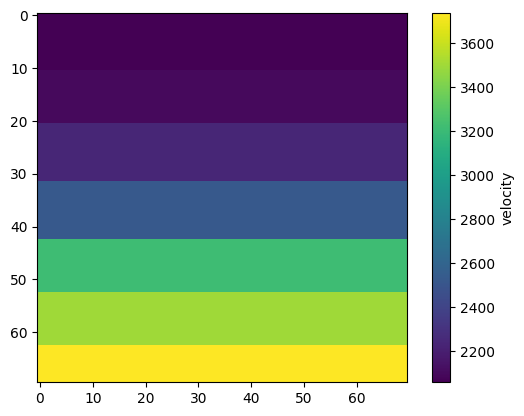

In [14]:
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')
plt.show()

In [15]:
mae=mean_absolute_error(torch.tensor(pred_vel).type(dtype).to(device), torch.tensor(vel).type(dtype).to(device))
print(mae.detach().cpu().numpy())

20.724854
